## BloomTech Data Science

---


# Define ML Problems
- Data Leakage
- ROC/AUC Curve



In [1]:
%%capture
import sys

# if on colab:
if 'google.colab' in sys.modules:
  DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
  !pip install category_encoders==2.*

# if working locally:
else:
  DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

In [3]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator
plot_roc_curve = RocCurveDisplay.from_estimator

In [4]:
pd.set_option('display.max_columns', 500)

# Define ML problems

# I. Wrangle Data

In [6]:
DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'

df = pd.read_csv(DATA_PATH + 'burritos/burritos.csv')

df.head(10)

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Pollos Maria,combo chicken,1/28/2016,NaN,NaN,NaN,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,3.5,2.5,2.5,2.5,4.0,1.0,3.20,NaN,Emily,NaN,NaN,NaN,NaN,NaN,x,x,NaN,x,NaN,x,NaN,NaN,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nico's Taco Shop,California,1/30/2016,Carmel Valley,3860 Valley Centre Dr #404,http://www.yelp.com/biz/nicos-taco-shop-san-diego,3.0,2.9,NaN,7.19,1.5,NaN,NaN,NaN,NaN,NaN,2.0,3.0,3.0,2.0,2.5,2.5,NaN,2.0,3.0,2.60,NaN,Scott,not fries. big potatoes,NaN,NaN,x,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Nico's Taco Shop,Carnitas,1/30/2016,NaN,NaN,NaN,NaN,NaN,NaN,6.99,4.0,NaN,NaN,NaN,NaN,NaN,2.5,3.0,3.0,2.5,3.0,3.5,NaN,2.5,3.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Los Primos Mexican Food,Monster California,2/1/2016,UTC,7770 Regents Rd,http://www.primosmex.com/,3.0,3.7,x,9.25,3.5,NaN,NaN,NaN,NaN,NaN,2.0,4.5,4.5,3.5,1.5,3.0,3.5,4.0,2.0,3.90,NaN,Scott,this tasted really bad leftover. not included ...,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,JV's Mexican Food,Carne Asada,2/6/2016,Morena,1112 Morena Blvd,http://jvsmexfood.com/,4.0,4.1,NaN,6.25,3.5,NaN,NaN,NaN,NaN,NaN,2.5,1.5,1.5,3.0,4.5,3.0,1.5,2.0,4.5,2.00,NaN,Scott,NaN,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.shape

(423, 66)

In [8]:
df['Beef'].value_counts()

,count
Beef,
x,138
X,42


In [9]:
def wrangle(filepath):

    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')

    # drop rows with no overall rating
    df.dropna(subset=['overall'], inplace=True)

    # Create `'great'` column as target
    df['great'] = (df['overall'] >= 4).astype(int) # 1 is great, 0 is not

    # Drop overall column to prevent data leakage
    df.drop(columns='overall', inplace=True)

    # Clean binary encoded columns
    categorical_cols = df.select_dtypes('object').columns

    # use categorical columns which are basically binary encoded
    binary_cols = [col for col in categorical_cols if df[col].nunique() < 4]
    for col in binary_cols:
        df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0) # if value x is a string

    # Drop high-cardinality categorical variables
    threshold = 20

    high_card_cols = [col for col in categorical_cols
                      if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)

    # Dropping columns with high number of NaN values
    df.dropna(axis=1, thresh=300, inplace=True)

    return df

In [10]:
df = wrangle(DATA_PATH + 'burritos/burritos.csv')
df.head(10)

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2016-01-28,6.99,4.0,3.0,4.0,5.0,3.5,2.5,2.5,2.5,4.0,1.0,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-30,7.19,1.5,2.0,3.0,3.0,2.0,2.5,2.5,NaN,2.0,3.0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-30,6.99,4.0,2.5,3.0,3.0,2.5,3.0,3.5,NaN,2.5,3.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-02-01,9.25,3.5,2.0,4.5,4.5,3.5,1.5,3.0,3.5,4.0,2.0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
df.info() # all data is numerical

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cost           414 non-null    float64
 1   Hunger         418 non-null    float64
 2   Tortilla       421 non-null    float64
 3   Temp           401 non-null    float64
 4   Meat           407 non-null    float64
 5   Fillings       418 non-null    float64
 6   Meat:filling   412 non-null    float64
 7   Uniformity     419 non-null    float64
 8   Salsa          396 non-null    float64
 9   Synergy        419 non-null    float64
 10  Wrap           418 non-null    float64
 11  Unreliable     421 non-null    int64  
 12  NonSD          421 non-null    int64  
 13  Beef           421 non-null    int64  
 14  Pico           421 non-null    int64  
 15  Guac           421 non-null    int64  
 16  Cheese         421 non-null    int64  
 17  Fries          421 non-null    int6

# II. Split Data

In [13]:
# classification because we have discrete values to work with
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

<Axes: xlabel='great'>

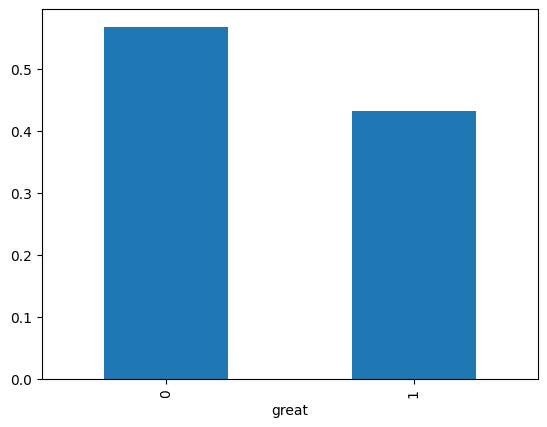

In [15]:
# need to check if target is balanced or not
# machine learning problems have been designed for an equal distribution
# anything better than 20% minority is balanced
y.value_counts(normalize=True).plot(kind='bar')

<Axes: >

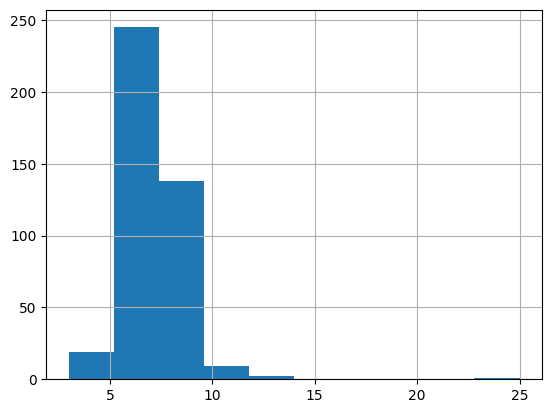

In [16]:
# checking skewness in regression
X['Cost'].hist()

In [19]:
# data aggregated by year
y.resample('YE').sum()

,great
Date,
2011-12-31,0
2012-12-31,0
2013-12-31,0
2014-12-31,0
2015-12-31,1
2016-12-31,121
2017-12-31,38
2018-12-31,13
2019-12-31,8


In [20]:
# Training
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation
validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

# Testing
test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

# III. Establish Baseline

In [22]:
y_train.value_counts()

,count
great,
0,176
1,122


In [21]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# IV. Build Model

In [23]:
# Model 1: Logistic Regression
# data sets has entirely numeric data so no need for an encoder

model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(), # scaling helps ensure models isn't biased to columns using large numbers (only linear models)
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [24]:
# Model 2: Random Forest
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_jobs=-1)
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

**Accuracy**
Correct predictions / total predictions

% of predictions the model got right

Could be erroneous because of imbalanced data - can mislead us

accuracy = (tp + tn) / (tp + fp + tn + fn)

In [25]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.912751677852349
Validation Accuracy (LOGR): 0.788235294117647


In [26]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.9176470588235294


**Precision, Recall, F1**

precision = tp / (tp + fp)

% of results which are relevant or accurately correct

recall = tp / (tp + fn)

% of total relevant results correctly classified by algorithm

Let's us know where the model went wrong

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.70      0.79        47
           1       0.71      0.89      0.79        38

    accuracy                           0.79        85
   macro avg       0.80      0.80      0.79        85
weighted avg       0.81      0.79      0.79        85



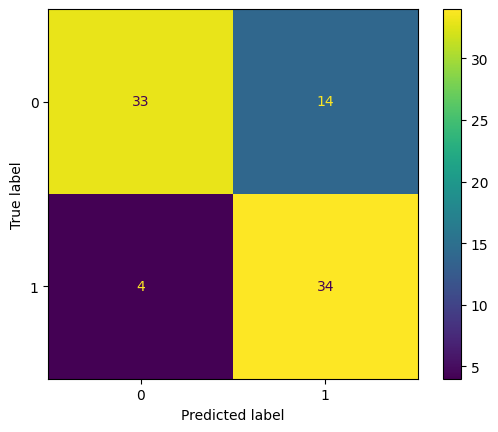

In [28]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val)

Random Forest
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        47
           1       0.92      0.89      0.91        38

    accuracy                           0.92        85
   macro avg       0.92      0.92      0.92        85
weighted avg       0.92      0.92      0.92        85



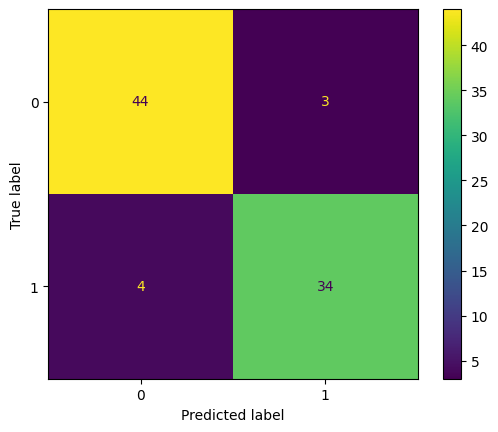

In [27]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val)

**ROC curve**


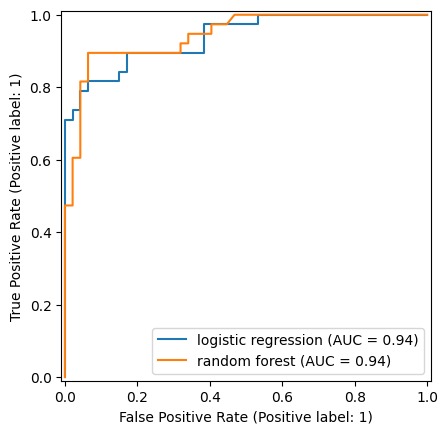

In [30]:
# receiver operating characteristic curve - evaluating binary classification
# take prediction probabilities as input
# another name for recall is sensitivity

lr = plot_roc_curve(
    model_lr,
    X_val,
    y_val,
    name='logistic regression'
)

rf = plot_roc_curve(
    model_rf,
    X_val,
    y_val,
    ax=lr.ax_,
    name='random forest'
)

In [31]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1]) # want the prob of the positive class

np.float64(0.9431690929451289)

In [32]:
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1]) # want the prob of the positive class

np.float64(0.9384098544232923)

In [33]:
# Get predicted probabilities from model
y_pred_prob = model_rf.predict_proba(X_val)[:, -1]

# Input true labels and probability predictions
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds': thresholds}

pd.DataFrame(data)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.026316,1.00
2,0.000000,0.078947,0.98
3,0.000000,0.157895,0.97
4,0.000000,0.184211,0.96
5,0.000000,0.289474,0.93
6,0.000000,0.315789,0.89
7,0.000000,0.473684,0.88
8,0.021277,0.473684,0.82
9,0.021277,0.526316,0.81


## Demonstrating how changing the threshold (from roc-auc curve) changes the metrics

In [38]:
y_pred_prob[y_pred_prob >= 0.60] = 1
y_pred_prob[y_pred_prob < 0.60] = 0

In [39]:
from sklearn.metrics import accuracy_score

print('Validation Accuracy (RF):', accuracy_score(y_val, y_pred_prob))

Validation Accuracy (RF): 0.9176470588235294


              precision    recall  f1-score   support

           0       0.92      0.94      0.93        47
           1       0.92      0.89      0.91        38

    accuracy                           0.92        85
   macro avg       0.92      0.92      0.92        85
weighted avg       0.92      0.92      0.92        85



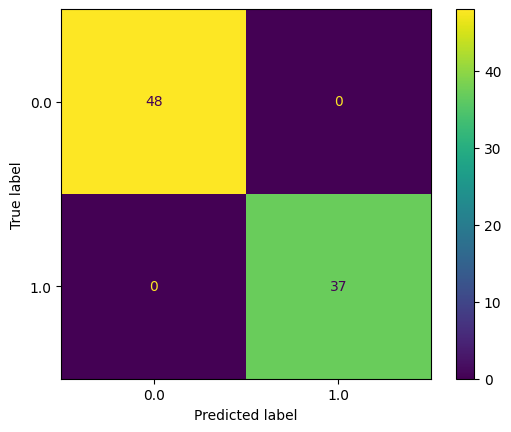

In [40]:
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_pred_prob);

## Regression Example

What if we were predicting the cost of a burrito?


In [51]:
target = 'Cost'
df_reg = wrangle(DATA_PATH + 'burritos/burritos.csv')
df_reg.dropna(inplace=True)
y = df_reg[target]
X = df_reg.drop(columns=target)

<Axes: >

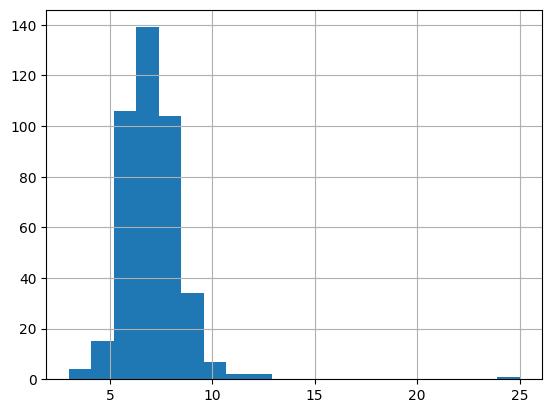

In [52]:
df['Cost'].hist(bins=20) # to check for target skewness

In [53]:
# Radomized Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [54]:
from sklearn.metrics import mean_absolute_error
baseline_pred = [y_val.mean()] * len(y_val)
mean_absolute_error(y_val, baseline_pred)

0.8772120080436654

In [56]:
from sklearn.linear_model import LinearRegression

model_lr = make_pipeline(SimpleImputer(),
                      StandardScaler(),
                      LinearRegression())

model_lr.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [57]:
from sklearn.ensemble import RandomForestRegressor

model_rf = make_pipeline(SimpleImputer(),
                      RandomForestRegressor())

model_rf.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestregressor', RandomForestRegressor())])

In [58]:
print("Training Accuracy - Linear Regression", mean_absolute_error(y_train, model_lr.predict(X_train)))
print("Validation Accuracy - Linear Regression", mean_absolute_error(y_val, model_lr.predict(X_val)))

Training Accuracy - Linear Regression 0.7226253033282242
Validation Accuracy - Linear Regression 0.9419879693895813


In [59]:
print("Training Accuracy - Random Forest", mean_absolute_error(y_train, model_rf.predict(X_train)))
print("Validation Accuracy - Random Forest", mean_absolute_error(y_val, model_rf.predict(X_val)))

Training Accuracy - Random Forest 0.3537953781512619
Validation Accuracy - Random Forest 0.8559254237288139


# Log Transformation of skewed Target (for regression)

In [ ]:
# The chosen target for the above example (burrito cost) is not skewed. But if your regression target is skewed, then you should log transform it, using the following steps:

# log transform your target (training set)
# y_train_log = np.log1p(y_train)

# fit your chosen model to this log tranformed target
# model.fit(X_train, y_train_log)

# get your predictions for this log tranformed target
# y_pred_log = model.predict(X_val)

# reverse log tranform your log tranformed target
# y_pred = np.expm1(y_pred_log)

# check your metrics
# print(mean_absolute_error(y_val, y_pred))


# Sampling of imbalance data (using .sample function)

This is just one way to over or under sample. Go over these links and read how to implement SMOTE(Synthetic Minority Oversampling Technique) technique too, where you create synthetic observations of the minority class!

* https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html
* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [ ]:
# # Sampling of imbalance data (using .sample function)

# # If train_minority contains only those rows in your training dataset that correspond to minority class, you can oversample like this.
# # When you over sample your minority class, you always have to sample with replacement

# num_minority_samples = 10 # number of additional minority class rows to create.
# train_minority_sample = train_minority.sample(num_minority_samples,replace = True)


# # If train_majority contains only those rows in your dataset that correspond to majority class, you can undersample like this.
# # Under sampling doesnt need with replacement
# num_majority_samples = 10 # number of majority class rows to remove.
# train_majority_sample = train_majority.sample(num_majority_samples,replace=False)

# # You can then append the two dataframes to form a final train df.
# train_final = train_minority_sample.append(train_majority_sample, ignore_index=True)
